In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path
from sqlalchemy import create_engine
from ds100_utils import fetch_and_cache

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)

In [2]:
import sqlite3
conn = sqlite3.connect('test.db')

In [3]:
conn.executescript("""
DROP TABLE IF EXISTS s;
DROP TABLE IF EXISTS t;

CREATE TABLE s(
    m INTEGER PRIMARY KEY, 
    u TEXT
);

INSERT INTO s VALUES 
    (1, 'W'),
    (2, 'X'),
    (3, 'X'),
    (4, 'Y');

CREATE TABLE t(
    n TEXT PRIMARY KEY, 
    v CHAR
);

INSERT INTO t VALUES 
    ('A', 'X'),
    ('B', 'X'),
    ('C', 'Y'),
    ('D', 'Z');
""");

In [4]:
def print_sql(s):
    print('>', s)
    for result in conn.execute(s):
        print(result)

print_sql('SELECT * FROM s;')
print_sql('SELECT * FROM t;')

> SELECT * FROM s;
(1, 'W')
(2, 'X')
(3, 'X')
(4, 'Y')
> SELECT * FROM t;
('A', 'X')
('B', 'X')
('C', 'Y')
('D', 'Z')


In [5]:
print_sql('SELECT * FROM s, t;')

> SELECT * FROM s, t;
(1, 'W', 'A', 'X')
(1, 'W', 'B', 'X')
(1, 'W', 'C', 'Y')
(1, 'W', 'D', 'Z')
(2, 'X', 'A', 'X')
(2, 'X', 'B', 'X')
(2, 'X', 'C', 'Y')
(2, 'X', 'D', 'Z')
(3, 'X', 'A', 'X')
(3, 'X', 'B', 'X')
(3, 'X', 'C', 'Y')
(3, 'X', 'D', 'Z')
(4, 'Y', 'A', 'X')
(4, 'Y', 'B', 'X')
(4, 'Y', 'C', 'Y')
(4, 'Y', 'D', 'Z')


In [6]:
print_sql('SELECT * FROM s JOIN t ON s.u = t.v;')
print_sql('SELECT * FROM s, t WHERE s.u = t.v;')


> SELECT * FROM s JOIN t ON s.u = t.v;
(2, 'X', 'A', 'X')
(2, 'X', 'B', 'X')
(3, 'X', 'A', 'X')
(3, 'X', 'B', 'X')
(4, 'Y', 'C', 'Y')
> SELECT * FROM s, t WHERE s.u = t.v;
(2, 'X', 'A', 'X')
(2, 'X', 'B', 'X')
(3, 'X', 'A', 'X')
(3, 'X', 'B', 'X')
(4, 'Y', 'C', 'Y')


In [7]:
print_sql('SELECT * FROM t LEFT JOIN s ON s.u = t.v')

> SELECT * FROM t LEFT JOIN s ON s.u = t.v
('A', 'X', 2, 'X')
('A', 'X', 3, 'X')
('B', 'X', 2, 'X')
('B', 'X', 3, 'X')
('C', 'Y', 4, 'Y')
('D', 'Z', None, None)


In [8]:
print_sql('SELECT s.m, s.u, t.n, t.v FROM t LEFT JOIN s ON s.u = t.v;')
print_sql('SELECT s.m, s.u, t.n, t.v FROM s LEFT JOIN t ON s.u = t.v UNION '
          'SELECT s.m, s.u, t.n, t.v FROM t LEFT JOIN s ON s.u = t.v;')

> SELECT s.m, s.u, t.n, t.v FROM t LEFT JOIN s ON s.u = t.v;
(2, 'X', 'A', 'X')
(3, 'X', 'A', 'X')
(2, 'X', 'B', 'X')
(3, 'X', 'B', 'X')
(4, 'Y', 'C', 'Y')
(None, None, 'D', 'Z')
> SELECT s.m, s.u, t.n, t.v FROM s LEFT JOIN t ON s.u = t.v UNION SELECT s.m, s.u, t.n, t.v FROM t LEFT JOIN s ON s.u = t.v;
(None, None, 'D', 'Z')
(1, 'W', None, None)
(2, 'X', 'A', 'X')
(2, 'X', 'B', 'X')
(3, 'X', 'A', 'X')
(3, 'X', 'B', 'X')
(4, 'Y', 'C', 'Y')


## IMDB Data

In [9]:
# From https://www.imdb.com/interfaces/
fetch_and_cache('https://datasets.imdbws.com/title.basics.tsv.gz', 'titles.tsv.gz')
fetch_and_cache('https://datasets.imdbws.com/name.basics.tsv.gz', 'names.tsv.gz')
!gunzip -kf data/titles.tsv.gz
!gunzip -kf data/names.tsv.gz
!ls -lh data

Downloading... Done!
Downloading... Done!
total 2712144
-rw-r--r--  1 sam  staff   539M Jul  5 12:11 names.tsv
-rw-r--r--  1 sam  staff   176M Jul  5 12:11 names.tsv.gz
-rw-r--r--  1 sam  staff   484M Jul  5 12:10 titles.tsv
-rw-r--r--  1 sam  staff   102M Jul  5 12:10 titles.tsv.gz


In [10]:
!head -n5 data/titles.tsv

tconst	titleType	primaryTitle	originalTitle	isAdult	startYear	endYear	runtimeMinutes	genres
tt0000001	short	Carmencita	Carmencita	0	1894	\N	1	Documentary,Short
tt0000002	short	Le clown et ses chiens	Le clown et ses chiens	0	1892	\N	5	Animation,Short
tt0000003	short	Pauvre Pierrot	Pauvre Pierrot	0	1892	\N	4	Animation,Comedy,Romance
tt0000004	short	Un bon bock	Un bon bock	0	1892	\N	\N	Animation,Short


In [11]:
!head -n5 data/names.tsv

nconst	primaryName	birthYear	deathYear	primaryProfession	knownForTitles
nm0000001	Fred Astaire	1899	1987	soundtrack,actor,miscellaneous	tt0043044,tt0050419,tt0053137,tt0072308
nm0000002	Lauren Bacall	1924	2014	actress,soundtrack	tt0038355,tt0117057,tt0037382,tt0071877
nm0000003	Brigitte Bardot	1934	\N	actress,soundtrack,producer	tt0049189,tt0054452,tt0057345,tt0059956
nm0000004	John Belushi	1949	1982	actor,writer,soundtrack	tt0080455,tt0078723,tt0077975,tt0072562


In [12]:
!wc data/*.tsv

 9429109 65046269 565579045 data/names.tsv
 5982407 81293691 507519002 data/titles.tsv
 15411516 146339960 1073098047 total


In [13]:
# How to crash your kernel:
# pd.read_csv('data/names.tsv', sep='\t')

In [14]:
# Instead, use sqlite3 (must be run from the terminal)
"""
$ sqlite3 imdb.db
sqlite> .mode tabs
sqlite> .import data/titles.tsv titles
sqlite> .import data/names.tsv names
""";

In [17]:
conn = sqlite3.connect('imdb.db')
print_sql('SELECT * FROM titles LIMIT 10;')

> SELECT * FROM titles LIMIT 10;
('tt0000001', 'short', 'Carmencita', 'Carmencita', '0', '1894', '\\N', '1', 'Documentary,Short')
('tt0000002', 'short', 'Le clown et ses chiens', 'Le clown et ses chiens', '0', '1892', '\\N', '5', 'Animation,Short')
('tt0000003', 'short', 'Pauvre Pierrot', 'Pauvre Pierrot', '0', '1892', '\\N', '4', 'Animation,Comedy,Romance')
('tt0000004', 'short', 'Un bon bock', 'Un bon bock', '0', '1892', '\\N', '\\N', 'Animation,Short')
('tt0000005', 'short', 'Blacksmith Scene', 'Blacksmith Scene', '0', '1893', '\\N', '1', 'Comedy,Short')
('tt0000006', 'short', 'Chinese Opium Den', 'Chinese Opium Den', '0', '1894', '\\N', '1', 'Short')
('tt0000007', 'short', 'Corbett and Courtney Before the Kinetograph', 'Corbett and Courtney Before the Kinetograph', '0', '1894', '\\N', '1', 'Short,Sport')
('tt0000008', 'short', 'Edison Kinetoscopic Record of a Sneeze', 'Edison Kinetoscopic Record of a Sneeze', '0', '1894', '\\N', '1', 'Documentary,Short')
('tt0000009', 'movie', 'Mis

In [18]:
for exp in conn.execute('SELECT sql FROM sqlite_master;'):
    print(exp[0])

CREATE TABLE titles(
  "tconst" TEXT,
  "titleType" TEXT,
  "primaryTitle" TEXT,
  "originalTitle" TEXT,
  "isAdult" TEXT,
  "startYear" TEXT,
  "endYear" TEXT,
  "runtimeMinutes" TEXT,
  "genres" TEXT
)
CREATE TABLE names(
  "nconst" TEXT,
  "primaryName" TEXT,
  "birthYear" TEXT,
  "deathYear" TEXT,
  "primaryProfession" TEXT,
  "knownForTitles" TEXT
)


In [19]:
# Python string substitution (new in Python 3.6)
who, where = 'John', 'here'
f"{who} is {where}"

'John is here'

In [20]:
key = 'tconst'
title = 'primaryTitle'
time = 'runtimeMinutes'
year = 'startYear'
adult = 'isAdult'
kind = 'titleType'

select_romance = f'''
    SELECT {key} AS id,
           {title} AS title, 
           CAST({time} AS int) AS time, 
           CAST({year} AS int) AS year
    FROM titles
    WHERE genres LIKE '%Romance%' AND
          year > 1900 AND 
          {adult} = '0' AND
          {kind} = 'movie' AND
          time > 60 AND time < 180
    '''
conn.executescript(f'''
    DROP TABLE IF EXISTS romance;
    CREATE TABLE romance AS {select_romance};
    ''')
print_sql('SELECT * FROM romance LIMIT 10')

> SELECT * FROM romance LIMIT 10
('tt0002026', 'Anny - Story of a Prostitute', 68, 1912)
('tt0004635', 'The Squaw Man', 74, 1914)
('tt0005073', 'The Chalice of Courage', 65, 1915)
('tt0005832', 'On the Night Stage', 62, 1915)
('tt0006359', 'The Americano', 61, 1916)
('tt0006456', 'La vie de Bohème', 112, 1916)
('tt0006614', 'The Dumb Girl of Portici', 112, 1916)
('tt0006719', 'The Girl Philippa', 70, 1916)
('tt0006728', "God's Country and the Woman", 80, 1916)
('tt0006780', "Hell's Hinges", 64, 1916)


In [26]:
df = pd.read_sql('SELECT * FROM romance', conn)
df

,id,title,time,year
0,tt0002026,Anny - Story of a Prostitute,68,1912
1,tt0004635,The Squaw Man,74,1914
2,tt0005073,The Chalice of Courage,65,1915
...,...,...,...,...
24053,tt9890850,Leyli va Macnun,93,1961
24054,tt9894202,Marala Telupana Priya,134,2016
24055,tt9899284,Return Of The Binman,120,2019


In [27]:
df.shape

(24056, 4)

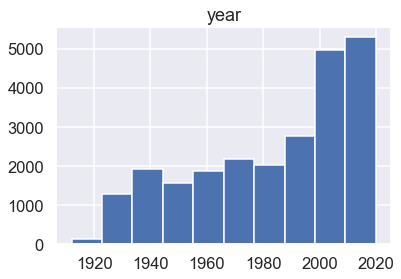

In [28]:
df.hist('year');

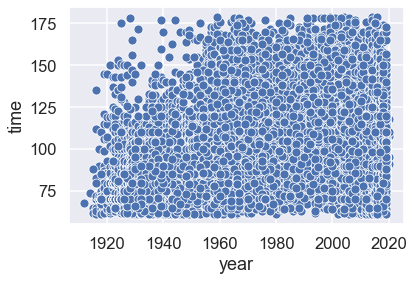

In [29]:
sns.scatterplot(df['year'], df['time']);

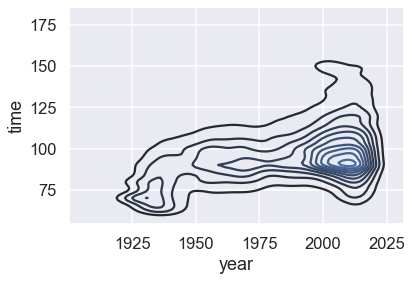

In [30]:
sns.kdeplot(df['year'], df['time']);

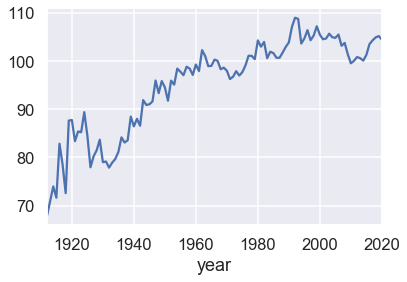

In [32]:
df['time'].groupby(df['year']).mean().plot();

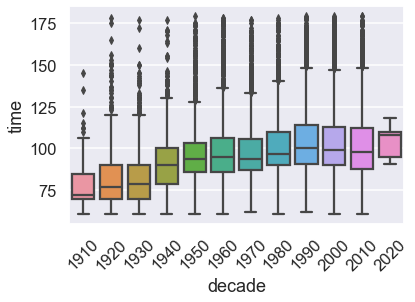

In [33]:
df['decade'] = (df['year'] // 10) * 10
sns.boxplot('decade', 'time', data=df)
plt.xticks(rotation=45);

In [34]:
pd.read_sql('SELECT * FROM romance ORDER BY RANDOM() LIMIT 3', conn)

,id,title,time,year
0,tt1343065,Trois baisers et 1000 de plus,95,2007
1,tt5077912,"White Lies, Black Lies",94,2015
2,tt0337512,My Favorite Season,100,1985


In [36]:
three_years = '''
    SELECT year FROM romance 
         GROUP BY year 
         ORDER BY RANDOM() LIMIT 3
    '''
cluster_sample = f'''
    SELECT * FROM romance 
    WHERE year IN ({three_years})
    '''
pd.read_sql(f'''
    SELECT year, COUNT(*) 
    FROM ({cluster_sample}) 
    GROUP BY year
    ''', conn)

,year,COUNT(*)
0,1915,3
1,1971,198
2,1995,276


In [37]:
pd.read_sql('SELECT * FROM names LIMIT 10;', conn)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0043044,tt0050419,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0117057,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,producer","tt0049189,tt0054452,tt0057345,tt0059956"
...,...,...,...,...,...,...
7,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0078788,tt0070849,tt0047296,tt0068646"
8,nm0000009,Richard Burton,1925,1984,"actor,producer,soundtrack","tt0087803,tt0057877,tt0061184,tt0059749"
9,nm0000010,James Cagney,1899,1986,"actor,soundtrack,director","tt0031867,tt0035575,tt0055256,tt0029870"


In [38]:
name = 'primaryName'
known = 'knownForTitles'
profession = 'primaryProfession'
born = 'birthYear'

select_actors = f'''
    SELECT {name} AS name, 
           CAST({born} AS int) AS born,
           SUBSTR({known}, 0, INSTR({known}, ',')) AS movie_id,
           CASE WHEN {profession} LIKE '%actor%' THEN 'actor' 
                WHEN {profession} LIKE '%actress%' THEN 'actress'   
                END AS profession
    FROM names
    WHERE {profession} LIKE '%act%' AND
          born > 1800
    '''
pd.read_sql(f'{select_actors} LIMIT 10', conn)

,name,born,movie_id,profession
0,Fred Astaire,1899,tt0043044,actor
1,Lauren Bacall,1924,tt0038355,actress
2,Brigitte Bardot,1934,tt0049189,actress
...,...,...,...,...
7,Marlon Brando,1924,tt0078788,actor
8,Richard Burton,1925,tt0087803,actor
9,James Cagney,1899,tt0031867,actor


In [39]:
select = f'''
    SELECT name, profession, born, title, year FROM
    ({select_actors}) JOIN
    romance
    ON movie_id = id;
    '''
conn.executescript(f'''
    DROP TABLE IF EXISTS romantics;
    CREATE TABLE romantics AS {select};
    ''')
pd.read_sql('SELECT * FROM romantics LIMIT 10', conn)

,name,profession,born,title,year
0,Brigitte Bardot,actress,1934,...And God Created Woman,1956
1,Ingrid Bergman,actress,1915,Spellbound,1945
2,Doris Day,actress,1922,Lover Come Back,1961
...,...,...,...,...,...
7,Cary Grant,actor,1904,To Catch a Thief,1955
8,Rita Hayworth,actress,1918,Gilda,1946
9,Audrey Hepburn,actress,1929,Charade,1963


In [40]:
pd.read_sql('''
    SELECT name, born, year,
       CASE WHEN born < 1980 THEN 'old' 
            WHEN born < 2000 THEN 'not too old' 
            ELSE 'young' END AS age,
       CASE year % 10 WHEN 0 THEN 'start of decade'
                      WHEN 5 THEN 'middle of decade'
                      END AS time
    FROM romantics
    ''', conn).sample(10)

,name,born,year,age,time
7374,Pat Keen,1933,1962,old,None
11055,Kirk Pengilly,1958,2009,old,None
12699,Jill Scott,1972,2013,old,None
...,...,...,...,...,...
3980,Stefano Dionisi,1966,1992,old,None
8336,Stanislav Lehký,1958,1995,old,middle of decade
1874,Dimitar Bochev,1926,1969,old,None


In [41]:
df = pd.read_sql('SELECT * FROM romantics', conn)
df.shape

(16875, 5)

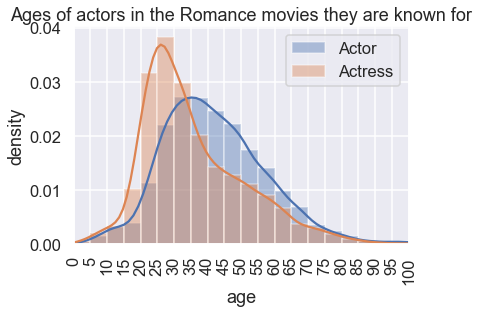

In [42]:
df['age'] = df['year'] - df['born']
bins = np.linspace(0, 100, 21)
sns.distplot(df[df['profession']=='actor']['age'], bins=bins)
sns.distplot(df[df['profession']=='actress']['age'], bins=bins)
plt.legend(labels=['Actor', 'Actress'])
plt.xticks(bins, rotation=90)
plt.xlim(0, 100)
plt.ylabel('density');
plt.title('Ages of actors in the Romance movies they are known for');